In [1]:
import copy
import os
import pickle
import random
import time

import networkx as nx
import numpy as np
import osmnx as ox
import pulp as pl
import requests
from dotenv import dotenv_values
from geopy.geocoders import Nominatim
from haversine import Unit, haversine_vector

ox.config(use_cache=True, log_console=True)

/home/terrabot/bk-imp/.venv/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


# Generate Warehouses and Stores

In [2]:
## Create OSM map of HCMC
if not os.path.exists("ho_chi_minh_city.graphml"):
    graph = ox.graph_from_place(
        "Ho Chi Minh City", network_type="drive", simplify=False
    )
    ox.save_graphml(graph, filepath="ho_chi_minh_city.graphml")
else:
    graph = ox.io.load_graphml("ho_chi_minh_city.graphml")

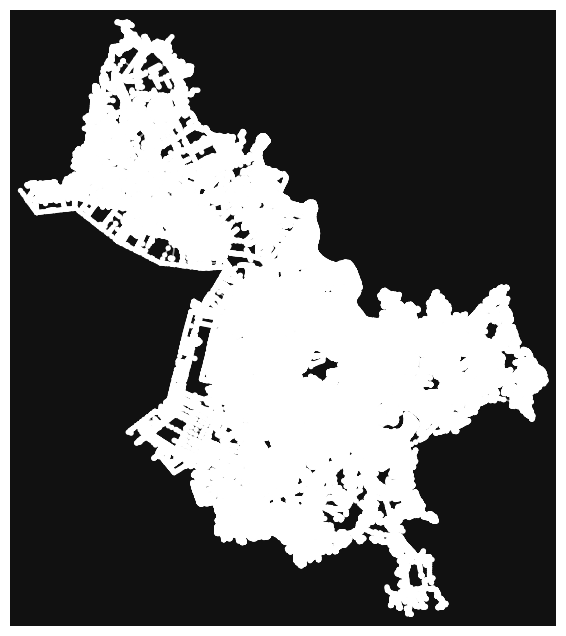

In [3]:
fig, ax = ox.plot_graph(graph)

In [31]:
# Obtain a list of nodes from the graph
nodes = list(graph.nodes)

chosen_locations = set()
# Generate random warehouses within the graph
warehouses = []
while len(warehouses) < 10000:
    # Select a random node
    random_node = random.choice(nodes)
    lat, long = graph.nodes[random_node]["y"], graph.nodes[random_node]["x"]
    warehouses.append((random_node, lat, long))
    chosen_locations.add(random_node)
with open("warehouses.pkl", "wb") as f:
    pickle.dump(warehouses, f)

# Generate random stores within the graph
stores = []
while len(stores) < 10000:
    # Select a random node
    random_node = random.choice(nodes)
    if random_node not in chosen_locations:
        lat, long = (
            graph.nodes[random_node]["y"],
            graph.nodes[random_node]["x"],
        )
        stores.append((random_node, lat, long))
with open("stores.pkl", "wb") as f:
    pickle.dump(stores, f)

# Direct Distance
In this approach, we make the assumption that the distance between two shops is independent of the road network.

In [6]:
M = 100  # Number of warehouses
N = 1000  # Number of stores

sampled_warehouses = random.choices(warehouses, k=M)
sampled_stores = random.choices(stores, k=N)

## Calculate Distance Matrix

In [7]:
dinstance_matrix = haversine_vector(
    [(store[1], store[2]) for store in sampled_stores],
    [(warehouse[1], warehouse[2]) for warehouse in sampled_warehouses],
    Unit.KILOMETERS,
    comb=True,
)

In [8]:
dinstance_matrix.shape

(100, 1000)

## Linear Programming

In [9]:
# Set up the problem
problem = pl.LpProblem("Warehouse_Optimization", pl.LpMinimize)

### Define the environment

In [10]:
warehouse_ids = range(M)
w_cost = random.sample(range(100, 201), M)  # Operational cost of warehouses
w_capacity = random.sample(
    range(13000, 15001), M
)  # Operational cost of warehouses
store_ids = range(N)
demands = random.sample(range(10, 1101), N)  # Daily demand of stores
d_cost = copy.copy(
    dinstance_matrix
)  # Delivery cost between warehouses vs stores

In [11]:
assert sum(w_capacity) > sum(
    demands
), "All warehouses' capacity is less than stores' demands"

### Define the decision variables

In [12]:
wr = pl.LpVariable.dicts(
    "warehouse_store_connection", (warehouse_ids, store_ids), cat="Binary"
)

### Define the objective function

In [13]:
total_cost = pl.lpSum(
    w_cost[w] * wr[w][s] + d_cost[w][s] * wr[w][s]
    for w in warehouse_ids
    for s in store_ids
)
problem += total_cost

### Define the constraints

In [14]:
# Each store must be assigned to one warehouse
for i in store_ids:
    problem += pl.lpSum(wr[j][i] for j in warehouse_ids) == 1

In [15]:
# Total demand of assigned stores for a warehouse must be smaller than its capacity
for w in warehouse_ids:
    problem += (
        pl.lpSum(demands[s] * wr[w][s] for s in store_ids) <= w_capacity[w]
    )

## Solve the problem!!!

### COIN-OR Branch and Cut solver (CBC)
https://coin-or.github.io/Cbc/intro.html#:~:text=The%20COIN%2DOR%20Branch%20and,executable%20version%20is%20also%20available.

In [ ]:
problem.solve(pl.PULP_CBC_CMD(timeLimit=120, threads=6, msg=0))

In [ ]:
# Print the total cost
print("Total Cost: ", pl.value(problem.objective))

### CPLEX Solver
Get it free from here https://www.ibm.com/academic/topic/data-science

or https://storage.googleapis.com/thaitang-sharing/cplex_studio2211.linux_x86_64.bin

In [16]:
os.environ["CPLEX_HOME"] = "/opt/ibm/ILOG/CPLEX_Studio2211/cplex"
os.environ["CPO_HOME"] = "/opt/ibm/ILOG/CPLEX_Studio2211/cpoptimizer"
os.environ["PATH"] += (
    ":"
    + os.environ["CPLEX_HOME"]
    + "/bin/x86-64_linux:"
    + os.environ["CPO_HOME"]
    + "/bin/x86-64_linux"
)
os.environ["LD_LIBRARY_PATH"] += (
    ":"
    + os.environ["CPLEX_HOME"]
    + "/bin/x86-64_linux:"
    + os.environ["CPO_HOME"]
    + "/bin/x86-64_linux"
)
os.environ[
    "PYTHONPATH"
] = "/opt/ibm/ILOG/CPLEX_Studio2211/cplex/python/3.10/x86-64_linux"

In [17]:
problem.solve(pl.CPLEX_CMD(timeLimit=120, threads=6, msg=0))

1

In [18]:
# Print the total cost
print("Total Cost: ", pl.value(problem.objective))

Total Cost:  118897.05735508681


# Actual Distance
Actual distance is calculated by calling the API of OpenStreetMap.

Note that the Openrouteservice API has a limit of 20 requests per minute for Isochrones.

In [24]:
def calculate_distance(graph, source_node, target_node):
    return (
        nx.shortest_path_length(
            graph, source_node, target_node, weight="length"
        )
        / 1000
    )

In [25]:
sampled_warehouses[0]

(6754296833, 10.84599, 106.7720656)

In [26]:
sampled_stores[10]

(5025518395, 10.7993146, 106.6092241)

In [27]:
print(
    calculate_distance(graph, sampled_warehouses[0][0], sampled_stores[10][0])
)

21.674531


In [30]:
# Update the actual distance from warehouse to assigned store
updated_cost = np.full_like(d_cost, False)
for w in warehouse_ids:
    for s in store_ids:
        if (pl.value(wr[w][s]) == 1) & (not updated_cost[w][s]):
            new_cost = calculate_distance(
                graph,
                sampled_warehouses[w][0],
                sampled_stores[s][0],
            )
            print(
                "Update cost from warehouse {} to store {} - {} to {}".format(
                    w, s, round(d_cost[w][s], 2), round(new_cost, 2)
                )
            )
            d_cost[w][s] = new_cost
            updated_cost[w][s] = True
            break

Update cost from warehouse 1 to store 7 - 11.86 to 11.86
Update cost from warehouse 6 to store 31 - 10.88 to 10.88
Update cost from warehouse 9 to store 4 - 10.29 to 10.29
Update cost from warehouse 11 to store 27 - 3.91 to 3.91
Update cost from warehouse 14 to store 144 - 7.42 to 7.42
Update cost from warehouse 17 to store 72 - 1.83 to 2.86
Update cost from warehouse 18 to store 73 - 2.57 to 3.36
Update cost from warehouse 19 to store 20 - 6.39 to 11.12
Update cost from warehouse 21 to store 286 - 1.93 to 2.19
Update cost from warehouse 24 to store 61 - 8.16 to 23.76
Update cost from warehouse 26 to store 58 - 5.15 to 7.87
Update cost from warehouse 30 to store 212 - 0.69 to 0.96
Update cost from warehouse 31 to store 12 - 3.26 to 5.09
Update cost from warehouse 34 to store 0 - 4.42 to 5.73
Update cost from warehouse 39 to store 68 - 8.16 to 13.16
Update cost from warehouse 40 to store 6 - 3.1 to 5.88
Update cost from warehouse 41 to store 111 - 0.39 to 0.67
Update cost from warehouse